# This notebook examines the effect of gene mutation on phosphorylation levels in various proteins.

### Particularly, the effect of truncation mutation on phosphorylation levels in the MSI subtype is investigated.

In this notebook, we look at the proteins ARID1A, AHNAK, KMT2D, FLNA, ADD3, and CTNNB1 and examine the result of mutation in their coding gene on the protein's phosphorylation level. Additionally, we compare this effect in the MSI and MSS subtypes, for truncation and other mutations. We do this by creating a dataframe, using the CPTAC package, in which all of the protein's phosphorylation sites and levels at that site are displayed, along with with the gene mutation status. Gene mutations are classified as truncation if they are nonsense or framshift mutations, and all other mutations are simply classified as other mutation. The MSI status is also added to this dataframe. We then do a t-test, comparing the difference in phosphorylation level for each site in our protein, when the coding gene is mutated as compared to when it is wildtype. We keep track of these p-values in a dictionary, and select the 5 most significant phosphorylation sites (these are the 5 sites which show the most significant difference in phosphorylation level between the mutated and wildtype groups). Finally, we create a plot showing the phosphorylation levels in these 5 sites, illustrating the data in 6 groups: <br>
MSI-Truncation<br>
MSI-Other Mutation <br>
MSI-Wildtype<br>
MSS-Truncation<br>
MSS-Other Mutation<br>
MSS-Wildtype

##### Import the necessary python packages, including the CPTAC endometrial dataset

In [3]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.stats.multitest
import CPTAC.Endometrial as CPTAC

##### Get the relevant data from CPTAC, including the phosphorylation data, and the clinical data, which outlines MSI subtype status.

In [30]:
phos = CPTAC.get_phosphoproteomics()
clinical = CPTAC.get_clinical()

msi_status = clinical['MSI_status']

## ARID1A

##### 1. Look at the ARID1A gene, and the effect of its mutation on ARID1A phosphorylation. Use the CPTAC compare mutations method to see how ARID1A phosphorylation is affected by ARID1A mutation.

In [31]:
gene = 'ARID1A'
prot = 'ARID1A'

'''Compare When gene is mutated'''
genedf = CPTAC.compare_mutations(phos, prot, gene)

##### 2. Make a list of all the phosphorylation sites on ARID1A. 

In [32]:
p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)

##### 3. For each phosphorylation site in ARID1A, seperate the dataframe into a mutated and wildtype group. do a t-test to compare the phosphorylation levels at the site when ARID1A is mutated vs when it is not. Keep track of this p-value in a dictionary.

In [33]:
'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]  

##### 4. Remove nan p-values from our p-value dictionary. (This eliminates phosphorylation sites that had high number of nan values)

In [34]:
'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]

##### 5. Sort the p-value dictionary, putting the most significant p-values first

In [35]:
'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))

##### 6. Grab the 5 most significant sites (the phosphorylation sites in ARID1A where phosphorylation levels were most significantly different between mutated and wildtype, based on p-value).

In [36]:
'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]

##### 7. Add these 5 most significant sites to a dataframe, in order to compare mutated and wildtype in these sites

In [37]:
'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype, as well as MSI vs MSS'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    plotdf = plotdf.join(pdf)

##### 8. Reformat the dataframe, changing all mutation types to simply read "mutation", so we can compare mutation with wildtype, and see the difference in phosphorylation levels.

In [38]:
'''Specify Truncation vs other mutations, wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncation',
                                      'Frame_Shift_Ins': 'Truncation',
                                      'Splice_Site' : 'Other Mutation',
                                      'In_Frame_Del' : 'Other Mutation',
                                      'In_Frame_Ins':'Other Mutation',
                                      'Nonsense_Mutation': 'Truncation',
                                      'Missense_Mutation': 'Other Mutation'
                                     }})

##### 9. Add MSI Status to our dataframe, enabling us to compare not only mutation with wildtype, but mutation and wildtype withing MSI and MSS subtypes

In [39]:
plotdf['MSI Status']= msi_status
plotdf = plotdf[pd.notnull(plotdf['MSI Status'])]

##### 10. Reformat the dataframe, dividing it into six groups: 
MSI - Truncation<br>
MSI - Other Mutation <br>
MSI - Wildtype <br> 
MSS - Truncation <br>
MSS - Other Mutation <br>
MSS - Wildtype

In [40]:
for ind, row in plotdf.iterrows():
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Other Mutation')
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Other Mutation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Truncation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Truncation')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Wildtype')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Wildtype')

plotdf = plotdf.drop('MSI Status', axis =1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecat

##### 11. Reformat the dataframe to allow us to plot the phosphorylation levels in these four groups, for the 5 most significant sites in ARID1A.

In [41]:
'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)

##### 12. Plot the data in our dataframe, showing the phosphorylation levels for the 5 most significant phosphorylation sites in ARID1A, in MSI and MSS truncation, other mutation, and wildtype groups.

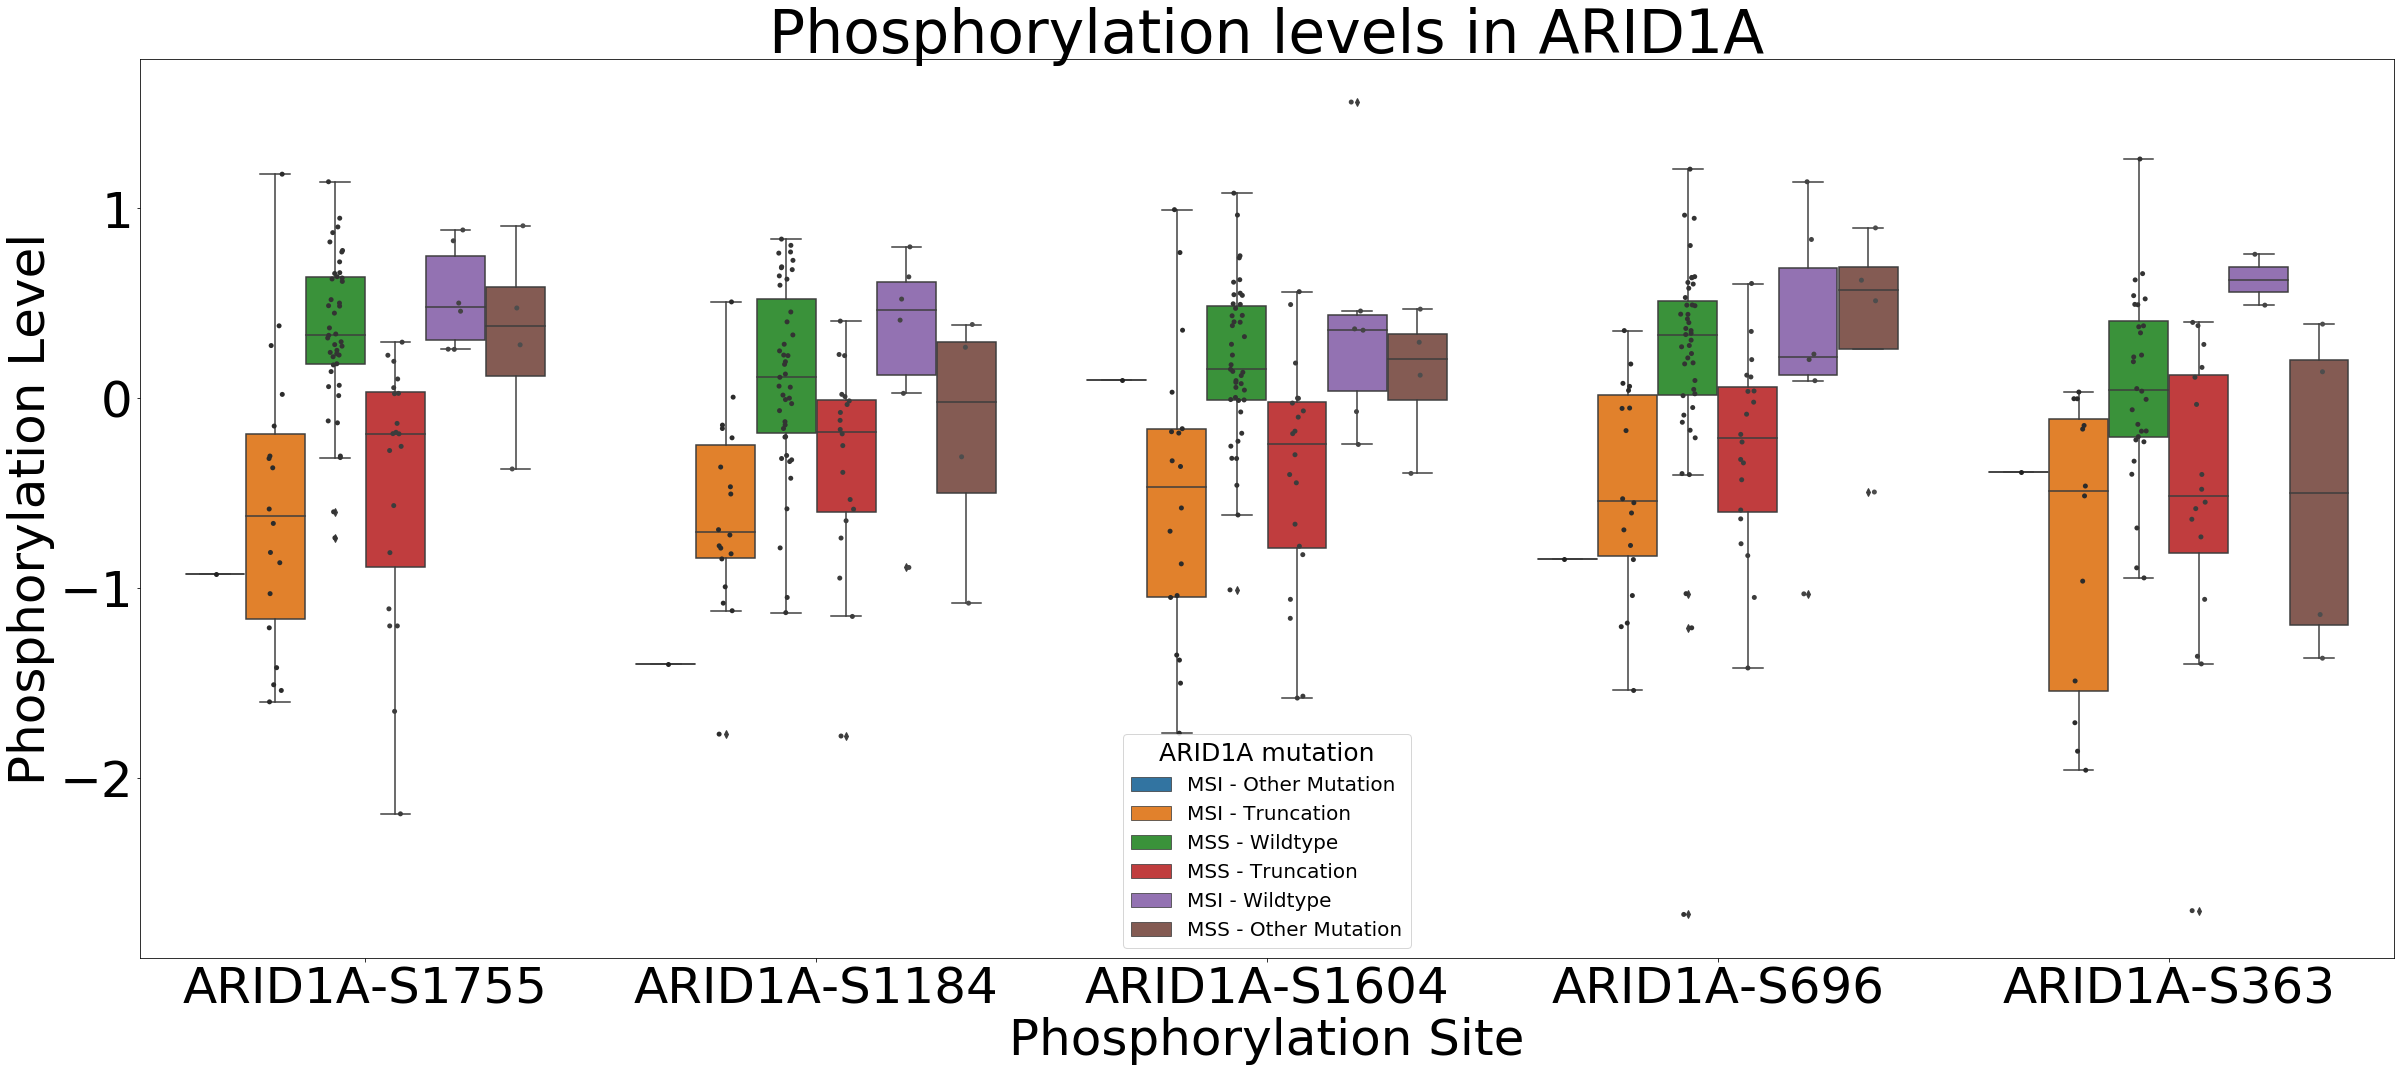

In [42]:
'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '60')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:6],labels[0:6],title=gene + ' mutation', fontsize='20')
boxplt.get_legend().get_title().set_fontsize('25')

## AHNAK

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_l

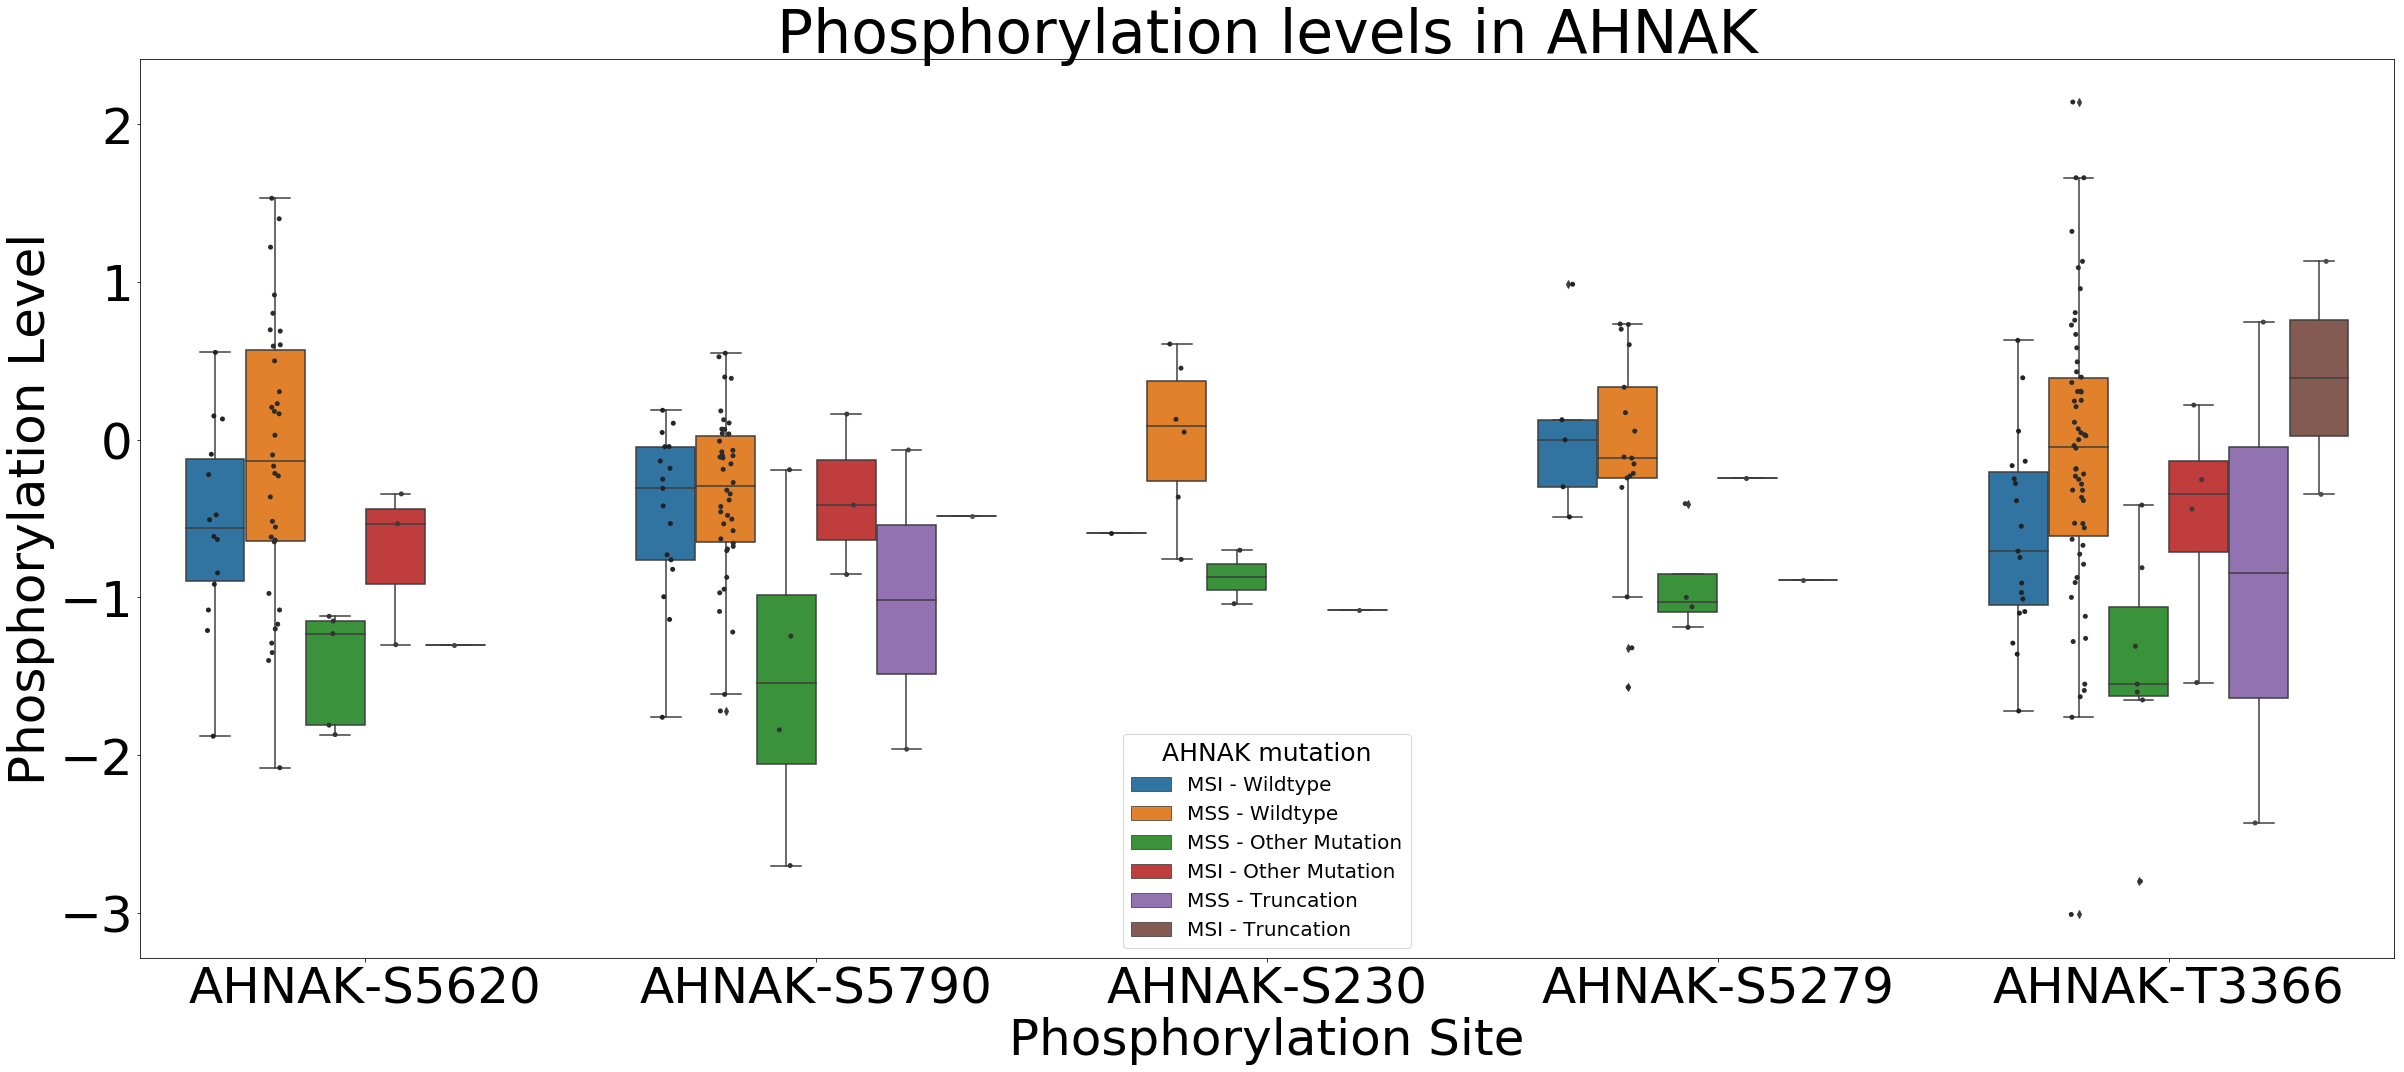

In [44]:
gene = 'AHNAK'
prot = 'AHNAK'

'''Compare When gene is mutated'''
genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)
        

'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]  
    
'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        
'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))


'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]


'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype, as well as MSI vs MSS'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    plotdf = plotdf.join(pdf)
    
    
'''Specify Truncation vs other mutations, wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncation',
                                      'Frame_Shift_Ins': 'Truncation',
                                      'Splice_Site' : 'Other Mutation',
                                      'In_Frame_Del' : 'Other Mutation',
                                      'In_Frame_Ins':'Other Mutation',
                                      'Nonsense_Mutation': 'Truncation',
                                      'Missense_Mutation': 'Other Mutation'
                                     }})

plotdf['MSI Status']= msi_status
plotdf = plotdf[pd.notnull(plotdf['MSI Status'])]


for ind, row in plotdf.iterrows():
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Other Mutation')
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Other Mutation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Truncation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Truncation')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Wildtype')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Wildtype')

plotdf = plotdf.drop('MSI Status', axis =1)

'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)

'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '60')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:6],labels[0:6],title=gene + ' mutation', fontsize='20')
boxplt.get_legend().get_title().set_fontsize('25')

## KMT2D

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_l

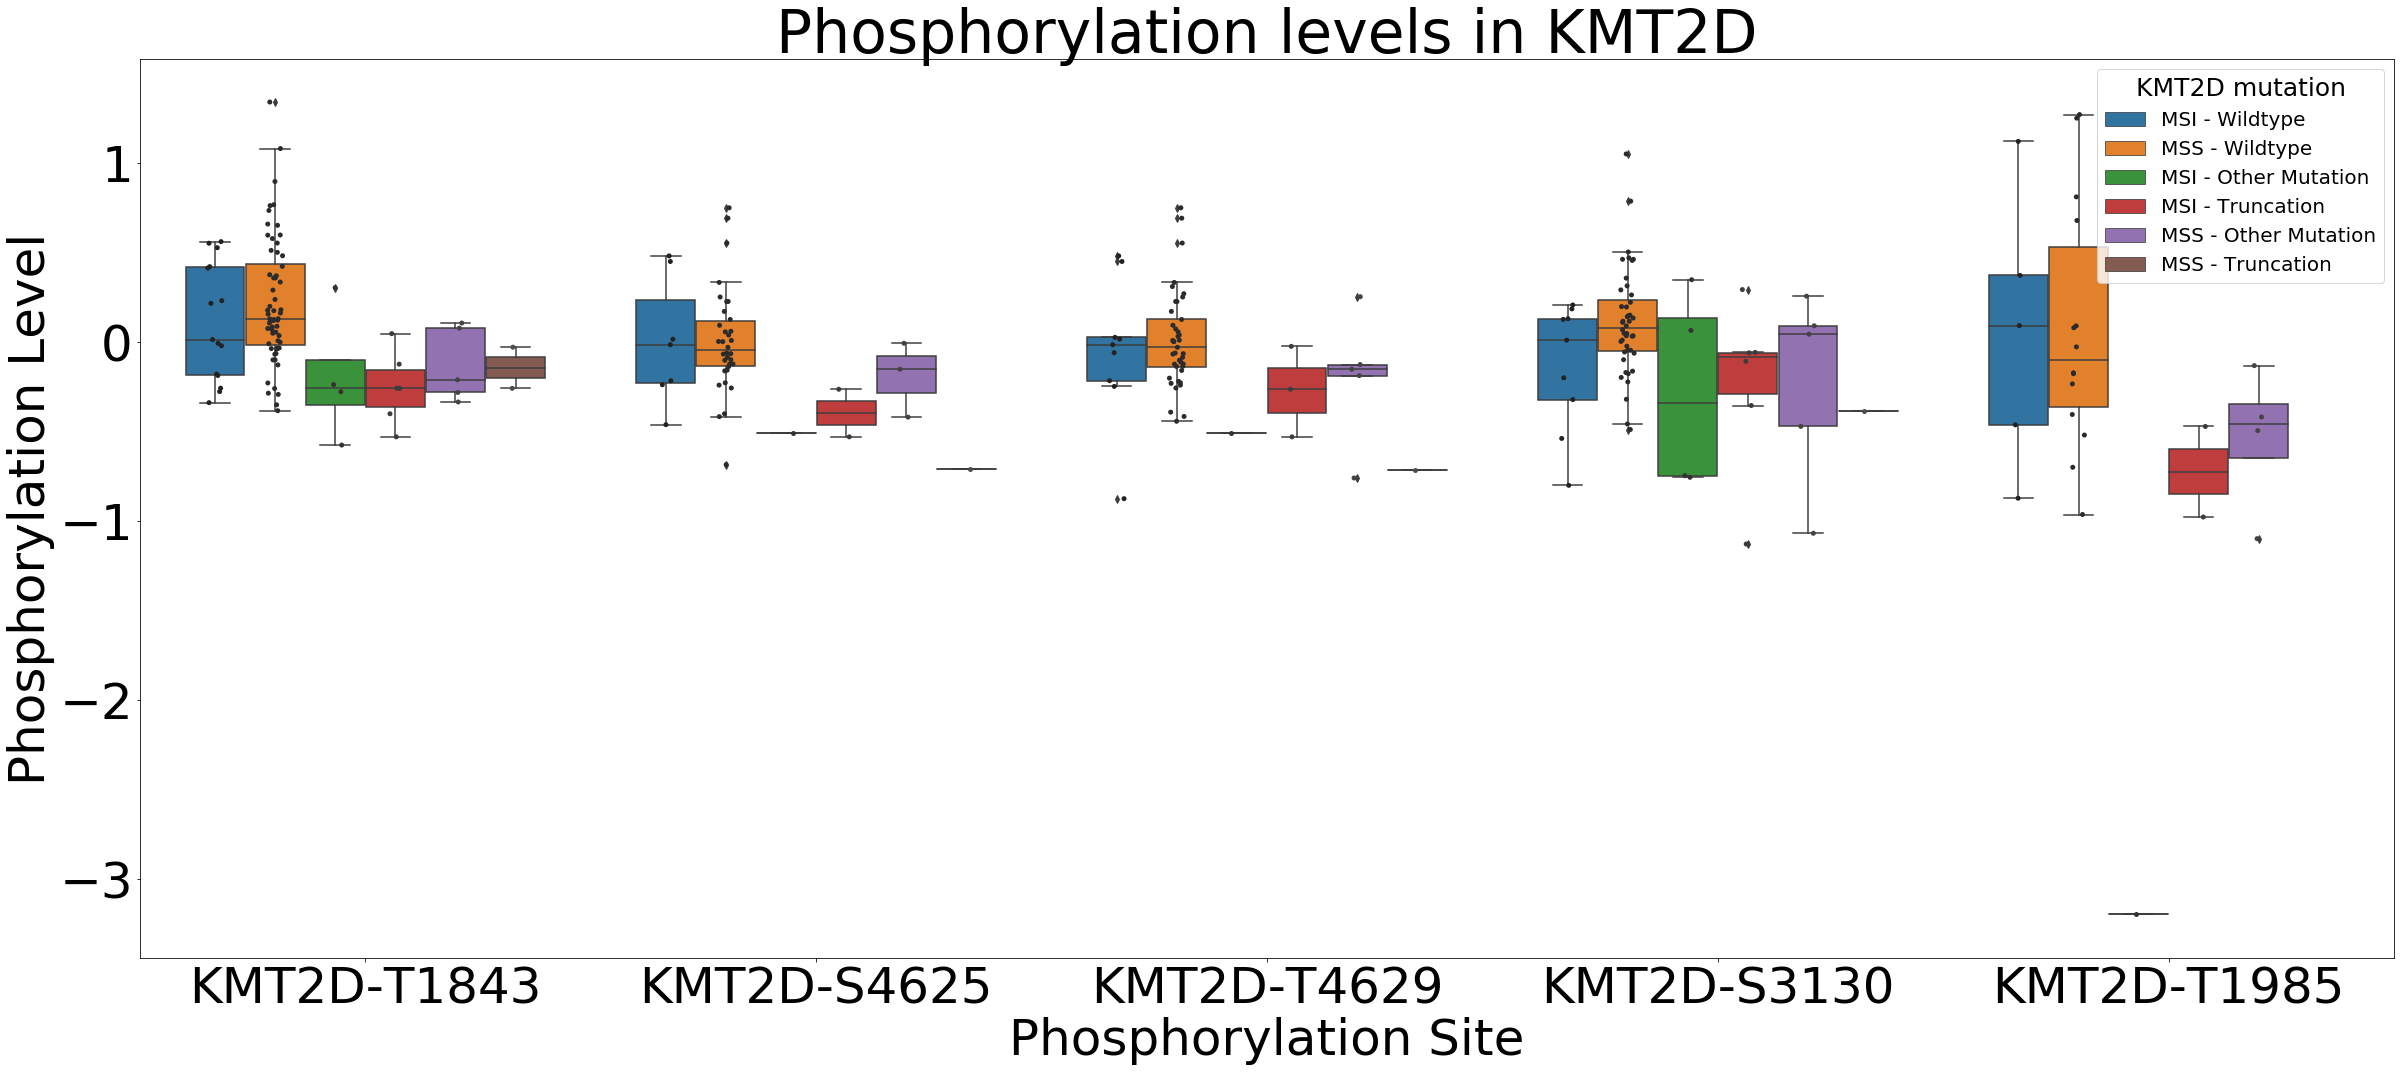

In [51]:
gene = 'KMT2D'
prot = 'KMT2D'

'''Compare When gene is mutated'''
genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)
        

'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]  
    
'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        
'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))


'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]


'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype, as well as MSI vs MSS'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    plotdf = plotdf.join(pdf)
    
    
'''Specify Truncation vs other mutations, wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncation',
                                      'Frame_Shift_Ins': 'Truncation',
                                      'Splice_Site' : 'Other Mutation',
                                      'In_Frame_Del' : 'Other Mutation',
                                      'In_Frame_Ins':'Other Mutation',
                                      'Nonsense_Mutation': 'Truncation',
                                      'Missense_Mutation': 'Other Mutation'
                                     }})

plotdf['MSI Status']= msi_status
plotdf = plotdf[pd.notnull(plotdf['MSI Status'])]


for ind, row in plotdf.iterrows():
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Other Mutation')
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Other Mutation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Truncation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Truncation')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Wildtype')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Wildtype')

plotdf = plotdf.drop('MSI Status', axis =1)

'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)

'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '60')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:6],labels[0:6],title=gene + ' mutation', fontsize='20')
boxplt.get_legend().get_title().set_fontsize('25')

## FLNA

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_l

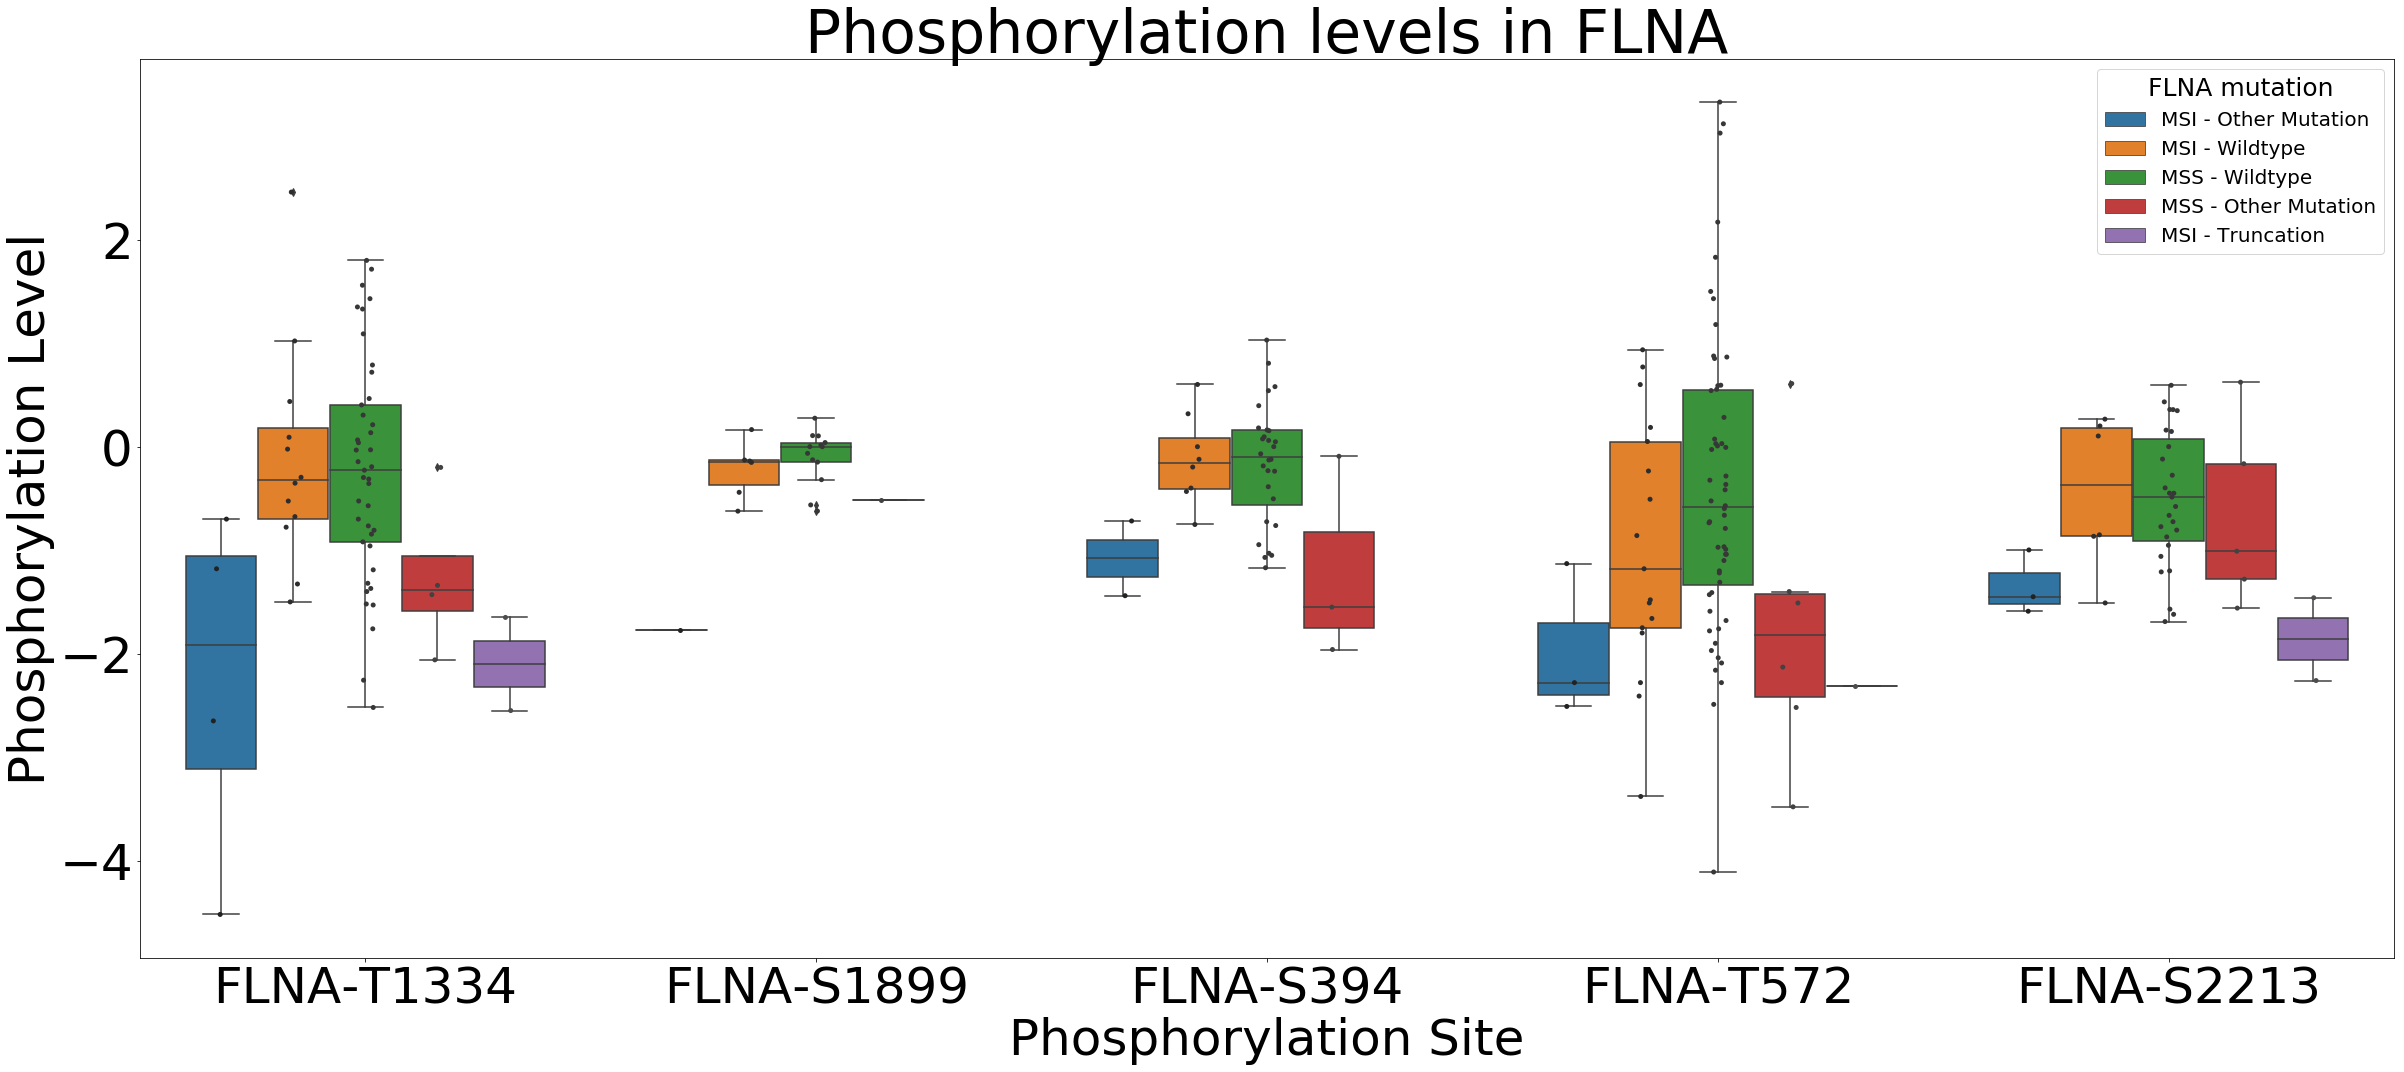

In [54]:
gene = 'FLNA'
prot = 'FLNA'

'''Compare When gene is mutated'''
genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)
        

'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]  
    
'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        
'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))


'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]


'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype, as well as MSI vs MSS'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    plotdf = plotdf.join(pdf)
    
    
'''Specify Truncation vs other mutations, wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncation',
                                      'Frame_Shift_Ins': 'Truncation',
                                      'Splice_Site' : 'Other Mutation',
                                      'In_Frame_Del' : 'Other Mutation',
                                      'In_Frame_Ins':'Other Mutation',
                                      'Nonsense_Mutation': 'Truncation',
                                      'Missense_Mutation': 'Other Mutation'
                                     }})

plotdf['MSI Status']= msi_status
plotdf = plotdf[pd.notnull(plotdf['MSI Status'])]


for ind, row in plotdf.iterrows():
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Other Mutation')
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Other Mutation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Truncation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Truncation')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Wildtype')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Wildtype')

plotdf = plotdf.drop('MSI Status', axis =1)

'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)

'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '60')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:5],labels[0:5],title=gene + ' mutation', fontsize='20')
boxplt.get_legend().get_title().set_fontsize('25')

## ADD3

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


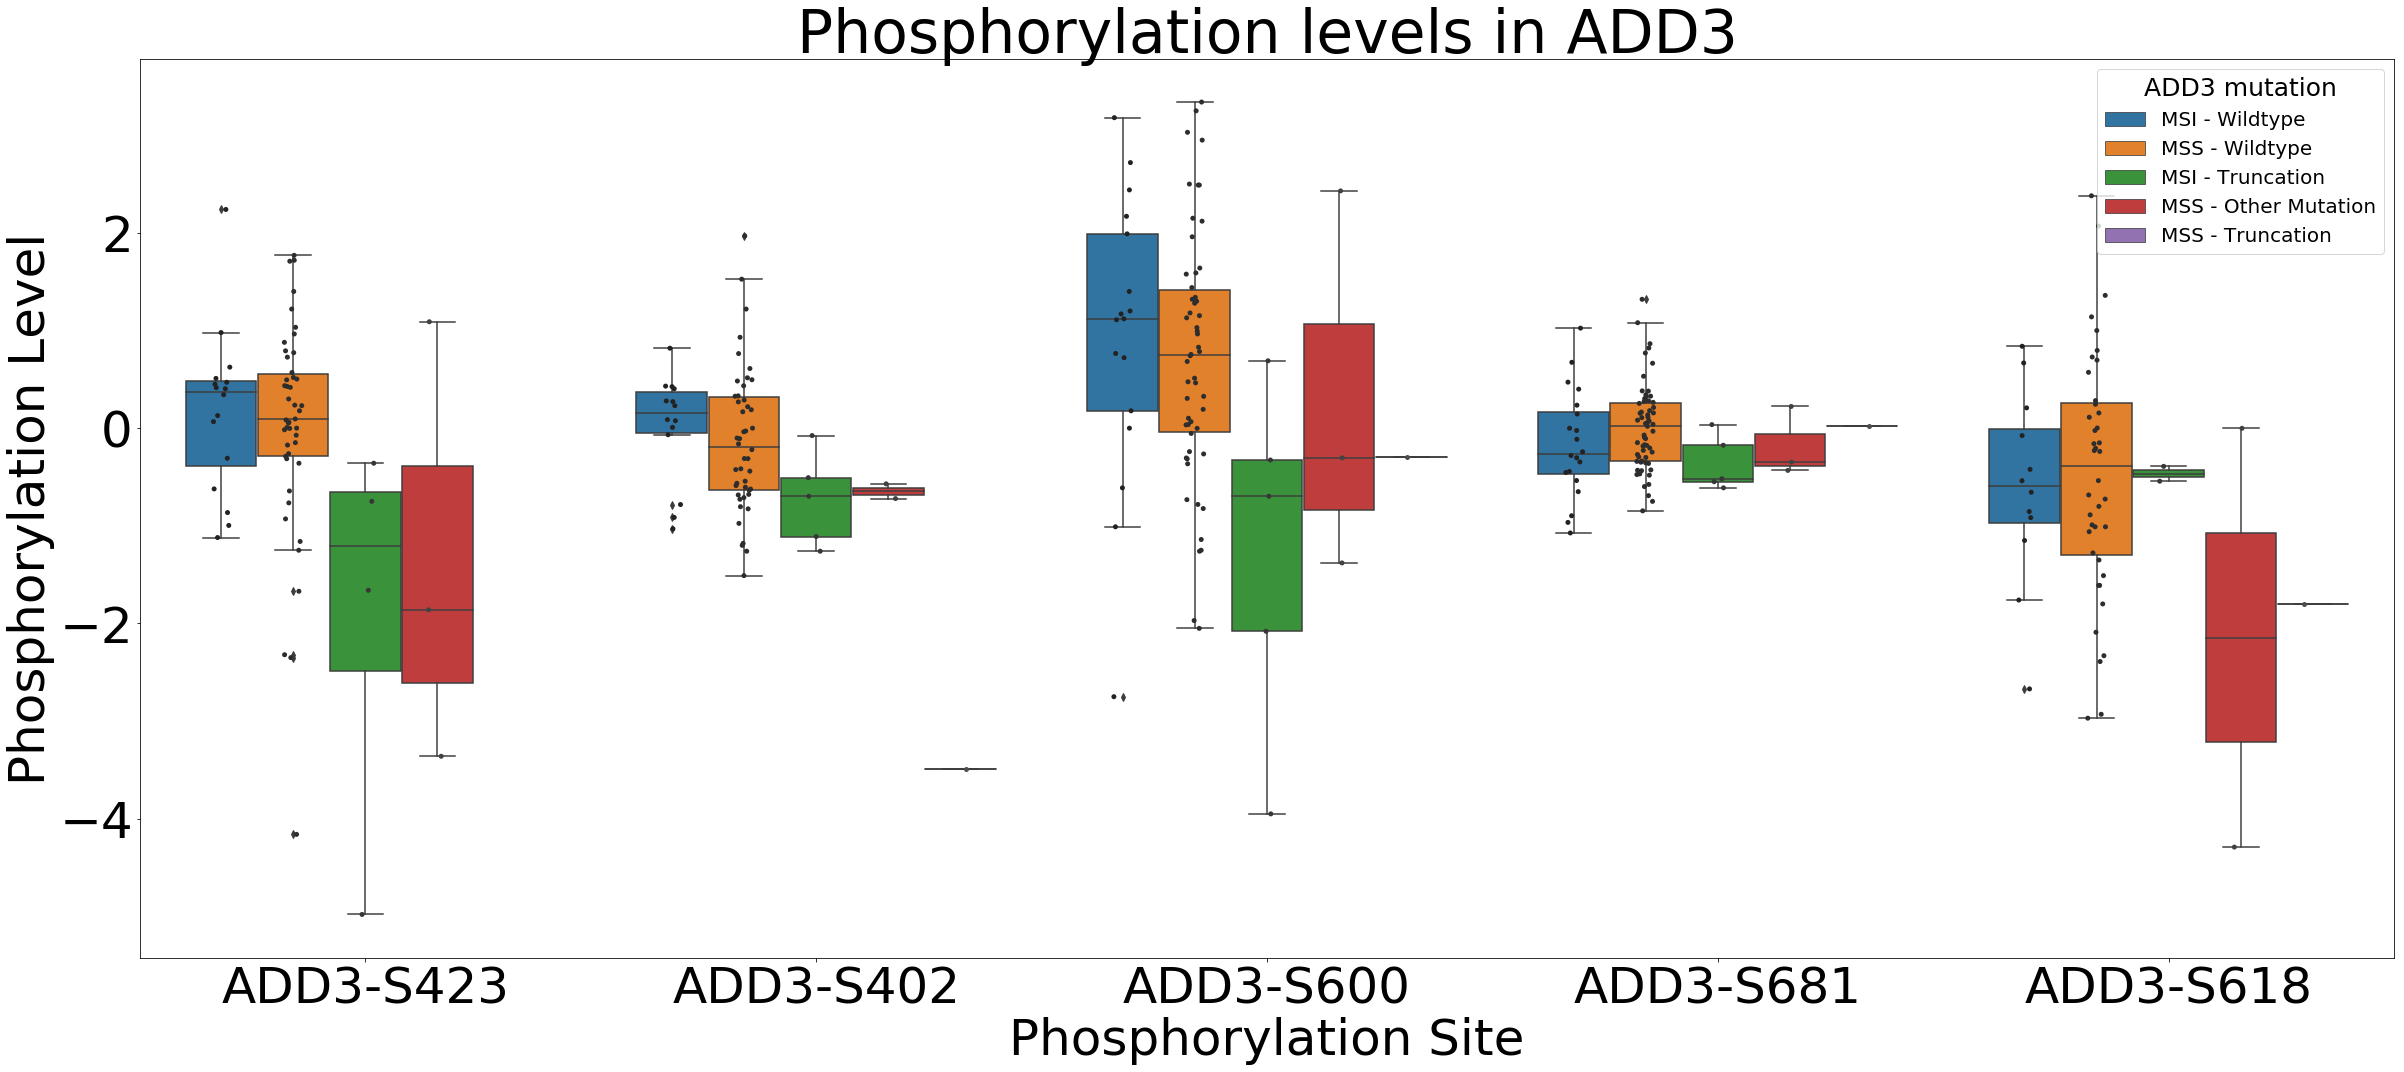

In [56]:
gene = 'ADD3'
prot = 'ADD3'

'''Compare When gene is mutated'''
genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)
        

'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]  
    
'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        
'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))


'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]


'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype, as well as MSI vs MSS'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    plotdf = plotdf.join(pdf)
    
    
'''Specify Truncation vs other mutations, wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncation',
                                      'Frame_Shift_Ins': 'Truncation',
                                      'Splice_Site' : 'Other Mutation',
                                      'In_Frame_Del' : 'Other Mutation',
                                      'In_Frame_Ins':'Other Mutation',
                                      'Nonsense_Mutation': 'Truncation',
                                      'Missense_Mutation': 'Other Mutation'
                                     }})

plotdf['MSI Status']= msi_status
plotdf = plotdf[pd.notnull(plotdf['MSI Status'])]


for ind, row in plotdf.iterrows():
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Other Mutation')
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Other Mutation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Truncation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Truncation')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Wildtype')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Wildtype')

plotdf = plotdf.drop('MSI Status', axis =1)

'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)

'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '60')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:5],labels[0:5],title=gene + ' mutation', fontsize='20')
boxplt.get_legend().get_title().set_fontsize('25')

## CTNNB1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:75: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:67: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


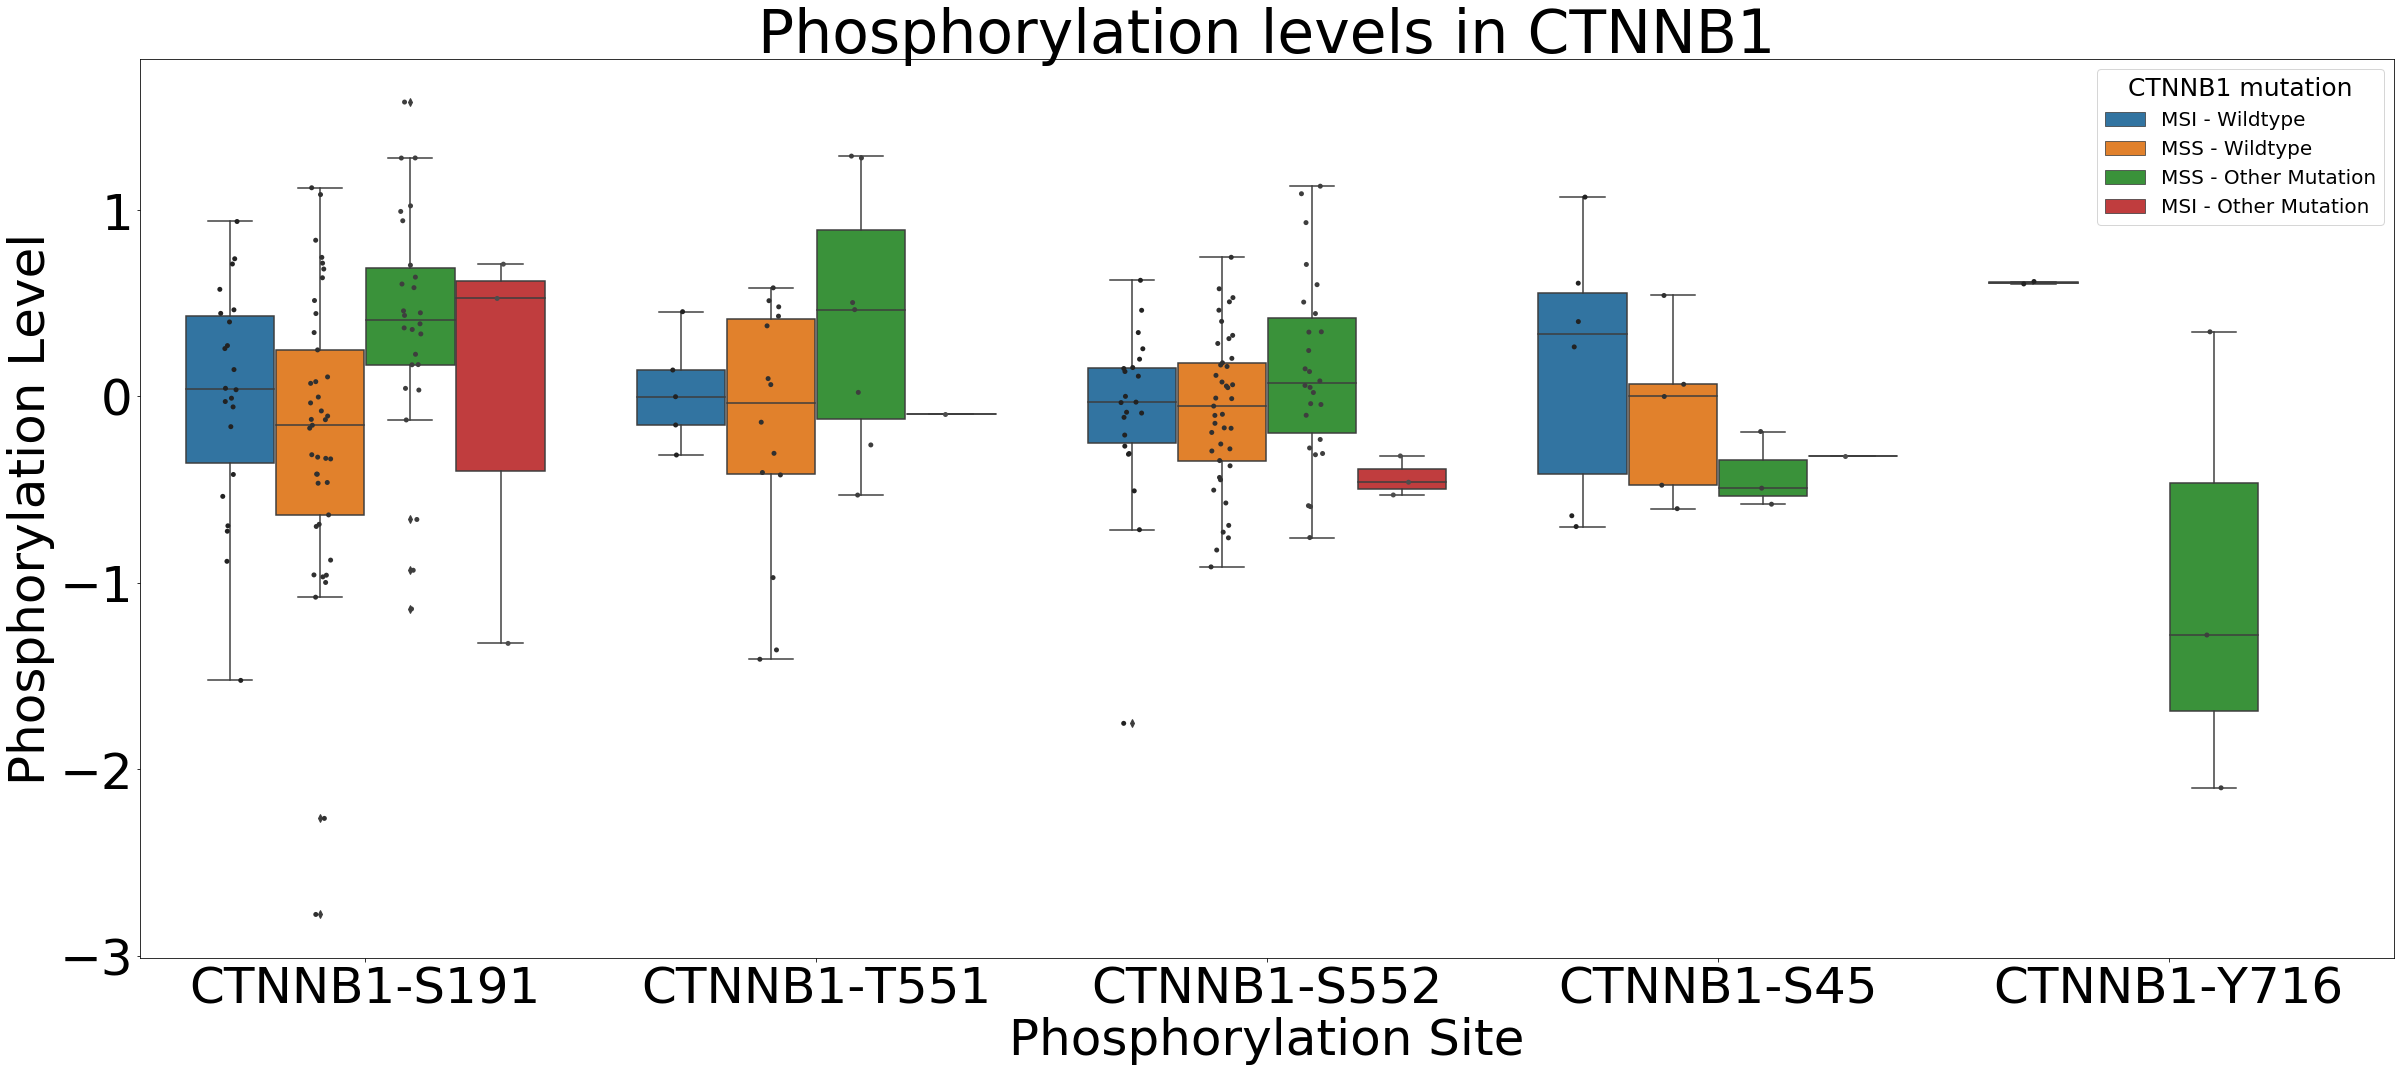

In [60]:
gene = 'CTNNB1'
prot = 'CTNNB1'

'''Compare When gene is mutated'''
genedf = CPTAC.compare_mutations(phos, prot, gene)

p_val_dict = {}
siteList = []

'''Make a list of all sites with the associated protein'''
for colName in genedf:
    if colName != "Mutation" and colName != "Patient_Type":
        siteList.append(colName)
        

'''Do a t-test on each site, comparing mutated vs wildtype phosphorylation levels'''
for site in siteList:
    phosdf = CPTAC.compare_mutations(phos, site, gene)
    phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1).dropna()
    mutateddf = phosdf.loc[phosdf['Mutation'] != 'Wildtype']
    wtdf = phosdf.loc[phosdf['Mutation'] == 'Wildtype']
    ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
    p_val_dict[site] = ttest[1]  
    
'''Remove nan p-values'''
for key in list(p_val_dict.keys()):
    if np.isnan(p_val_dict[key]):
        del p_val_dict[key]
        
'''Sort the dictionary for most significant p-values'''
sorted_dict = dict(sorted(p_val_dict.items(), key=lambda kv: kv[1]))


'''Get the 5 most significant sites'''
five_most_sig_sites = []
for key in sorted_dict.keys():
    five_most_sig_sites.append(key)
five_most_sig_sites = five_most_sig_sites[:5]


'''Make a dataframe showing phosphorylation levels at these 5 sites, comparing mutated vs wildtype, as well as MSI vs MSS'''
plotdf = CPTAC.compare_mutations(phos, gene)
plotdf = plotdf.loc[plotdf['Patient_Type'] == 'Tumor'][['Mutation']]
for site in five_most_sig_sites:
    pdf = CPTAC.compare_mutations(phos, site, gene)[[site]]
    plotdf = plotdf.join(pdf)
    
    
'''Specify Truncation vs other mutations, wildtype'''
plotdf = plotdf.replace({'Mutation': {'Frame_Shift_Del': 'Truncation',
                                      'Frame_Shift_Ins': 'Truncation',
                                      'Splice_Site' : 'Other Mutation',
                                      'In_Frame_Del' : 'Other Mutation',
                                      'In_Frame_Ins':'Other Mutation',
                                      'Nonsense_Mutation': 'Truncation',
                                      'Missense_Mutation': 'Other Mutation'
                                     }})

plotdf['MSI Status']= msi_status
plotdf = plotdf[pd.notnull(plotdf['MSI Status'])]


for ind, row in plotdf.iterrows():
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Other Mutation')
    if row['Mutation'] == 'Other Mutation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Other Mutation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Truncation')
    if row['Mutation'] == 'Truncation' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Truncation')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSI-H':
        plotdf.set_value(ind, 'Mutation', 'MSI - Wildtype')
    if row['Mutation'] == 'Wildtype' and row['MSI Status'] == 'MSS':
        plotdf.set_value(ind, 'Mutation', 'MSS - Wildtype')

plotdf = plotdf.drop('MSI Status', axis =1)

'''Reformat dataframe to plot'''
plotdf = pd.melt(plotdf, id_vars=['Mutation'], var_name='Site', value_name='Phosphorylation')
plotdf = plotdf.dropna(axis=0)

'''plot data'''
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
boxplt = sns.boxplot(x='Site', y='Phosphorylation', hue='Mutation', data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phosphorylation', hue='Mutation', dodge=True, jitter=True, color='.3')

boxplt.set_xlabel('Phosphorylation Site', fontsize='50')
boxplt.set_ylabel('Phosphorylation Level', fontsize='50')
boxplt.tick_params(labelsize='50')
boxplt.set_title('Phosphorylation levels in ' + gene, fontsize = '60')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:4],labels[0:4],title=gene + ' mutation', fontsize='20')
boxplt.get_legend().get_title().set_fontsize('25')